# 2019 March madness tournament

In [2]:
# Import libraries needed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#### Load and process data

In [5]:
# Read in data
directory = 'G:/My Drive/Research Work/7 Kaggle/2019 NCAA/mens-machine-learning-competition-2019/DataFiles/'
df_teams_seeds = pd.read_csv(directory + 'NCAATourneySeeds.csv')

# Strip letters in seed column an return an integer
df_teams_seeds['Seed'] = df_teams_seeds['Seed'].apply(lambda x: int(x[1:3]))
df_teams_seeds.head()

,Season,Seed,TeamID
0,1985,1,1207
1,1985,2,1210
2,1985,3,1228
3,1985,4,1260
4,1985,5,1374


In [6]:
df_tournament_results = pd.read_csv(directory + 'NCAATourneyCompactResults.csv')
df_tournament_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [7]:
#Merge two dataframes and calculate the seed difference
df_renamed_win = df_teams_seeds.rename(columns={'TeamID':'WTeamID','Seed':'WSeed'})
df_renamed_loss = df_teams_seeds.rename(columns={'TeamID':'LTeamID','Seed':'LSeed'})
df_mixed = df_tournament_results.merge(df_renamed_win, how='left', on=['Season','WTeamID'])
df_final = df_mixed.merge(df_renamed_loss, how='left', on=['Season','LTeamID'])
df_final['SeedDifference'] = df_final['WSeed'] - df_final['LSeed'] 
df_final['ScoreDifference'] = df_final['WScore'] - df_final['LScore']
df_final.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,SeedDifference,ScoreDifference
0,1985,136,1116,63,1234,54,N,0,9,8,1,9
1,1985,136,1120,59,1345,58,N,0,11,6,5,1
2,1985,136,1207,68,1250,43,N,0,1,16,-15,25
3,1985,136,1229,58,1425,55,N,0,9,8,1,3
4,1985,136,1242,49,1325,38,N,0,3,14,-11,11


# Create the training data:

In [8]:
# Create array with seed differences and wins as 1
df_wins = pd.DataFrame()
df_wins['SeedDifference'] = df_final['SeedDifference']
df_wins['ScoreDifference'] = df_final['ScoreDifference']
df_wins['Result'] = 1
#df_wins.head()

# Create array with seed differences and losses as 0
df_losses = pd.DataFrame()
df_losses['SeedDifference'] = -df_final['SeedDifference']
df_losses['ScoreDifference'] = -df_final['ScoreDifference']
df_losses['Result'] = 0
#df_losses.head()

# Concatenate two dataframes vertically
training_data = pd.concat([df_losses, df_wins], axis=0)
training_data.head()

,SeedDifference,ScoreDifference,Result
0,-1,-9,0
1,-5,-1,0
2,15,-25,0
3,-1,-3,0
4,11,-11,0


# Cross-validated grid search with Logistic Regression as the estimator

## Model1:Only one feature maps on win or loss

In [10]:
X_train = training_data.SeedDifference.values.reshape(-1,1)
y_train = training_data.Result.values
#X_train, y_train = shuffle(X_train, y_train)
logreg = LogisticRegression()
params = {'C': np.logspace(start=-10, stop=10, num=30)} #Parmeter of ML model
model1 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True, cv=4)
model1.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(model1.best_score_, model1.best_params_['C']))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best log_loss: -0.5552, with best C: 0.00385662042116


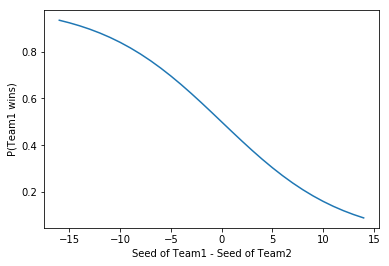

In [12]:
# PLotting propabilities of the ML  model for SeedDifferences
X = np.arange(-16, 15).reshape(-1, 1)
predictions = model1.predict_proba(X)[:,1]
#print X.shape
#print X
#print predictions.shape
#print predictions
plt.plot(X, predictions)
plt.xlabel('Seed of Team1 - Seed of Team2')
plt.ylabel('P(Team1 wins)')
plt.show()

The higher ranked seed has a higher probability of winning, e.g. P(Seed1-Seed16)= P(-15) ~ 0.95

## Model2: Both features map on win or loss

In [13]:
X_train2 = training_data[['SeedDifference','ScoreDifference']].values.reshape(-1,2)
y_train2 = training_data.Result.values
#X_train, y_train = shuffle(X_train, y_train)
logreg = LogisticRegression()
params = {'C': np.logspace(start=-10, stop=10, num=30)} #Parmeter of ML model
model2 = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True, cv=4)
model2.fit(X_train2, y_train2)
print('Best log_loss: {:.4}, with best C: {}'.format(model2.best_score_, model2.best_params_['C']))

Best log_loss: -0.0002625, with best C: 10000000000.0


In [15]:
# PLotting propabilities of the ML  model for SeedDifferences
X2 = np.array(np.arange(-15,16)).reshape(-1, 1)
#X3 = np.array([np.arange(-15,16), np.zeros(31)]).transpose()
predictions = model2.predict_proba(X2)[:,1]
#print X.shape
#print X
print predictions.shape
print predictions
plt.plot(X2, predictions)
plt.xlabel('Seed of Team1 - Seed of Team2')
plt.ylabel('P(Team1 wins)')
plt.show()

ValueError: X has 1 features per sample; expecting 2

# Preparing the submission file

In [4]:
# Get sample submission file
directory2 = 'G:/My Drive/Research Work/7 Kaggle/2019 NCAA/mens-machine-learning-competition-2019/'

df_sample_submission = pd.read_csv(directory2 + 'SampleSubmissionStage1.csv')
n_test_games = len(df_sample_submission)

def get_tuple(ID):
    """Return a tuple with the year, team one and team two match up."""
    return (int(x) for x in ID.split('_'))

X_for_prediction = np.zeros(shape=(n_test_games, 1))
print df_sample_submission.head()

               ID  Pred
0  2014_1107_1110   0.5
1  2014_1107_1112   0.5
2  2014_1107_1113   0.5
3  2014_1107_1124   0.5
4  2014_1107_1140   0.5


In [10]:
# extract the SeedDifference form each matchup from the submission file and store it in X_predic
for index, row in df_sample_submission.iterrows():
    year, team1, team2 = get_tuple(row.ID)
    team1_seed = df_teams_seeds[(df_teams_seeds.TeamID == team1) & (df_teams_seeds.Season == year)].Seed.values[0]
    team2_seed = df_teams_seeds[(df_teams_seeds.TeamID == team2) & (df_teams_seeds.Season == year)].Seed.values[0]
    diff_seed = team1_seed - team2_seed
    X_predic[index, 0] = diff_seed

# Making predictions and exporting

In [18]:
# Here we use the data prepared from the 'Preparing submission file'
predictions = clf.predict_proba(X_predic)[:,1]

clipped_predictions = np.clip(predictions, 0.03, 0.97)
df_sample_submission.Pred = clipped_predictions
df_sample_submission.head()

,ID,Pred
0,2014_1107_1110,0.458778
1,2014_1107_1112,0.077349
2,2014_1107_1113,0.270603
3,2014_1107_1124,0.160756
4,2014_1107_1140,0.270603


In [19]:
df_sample_submission.to_csv('Seed_submission.csv', index=False)